In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import warnings
import tensorflow as tf
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Seems like the new one will break jax
#!pip install --upgrade jax jaxlib==0.4.3 git+https://github.com/deepmind/optax.git flax optax -q
    
if 'TPU_NAME' in os.environ and 'KAGGLE_DATA_PROXY_TOKEN' in os.environ:
    use_tpu = True
    
    import requests 
    from jax.config import config
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    # Enforce bfloat16 multiplication
    config.update('jax_default_matmul_precision', 'bfloat16')
    print('Registered (Kaggle) TPU:', config.FLAGS.jax_backend_target)
else:
    use_tpu = False

In [ ]:
    
import jax
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

In [ ]:
import functools
from tqdm.notebook import tqdm

import jax.numpy as jnp
from jax import lax 

import flax
import flax.linen as nn
from flax.core import freeze, unfreeze
from flax.core.frozen_dict import FrozenDict
from flax.training.common_utils import shard, shard_prng_key
from flax.serialization import to_state_dict, from_state_dict,\
                        msgpack_serialize, msgpack_restore, from_bytes

import optax
import msgpack
#from jax_efficientnetv2 import efficientnet_v2_pretrained

# Apologies for shamelessly oppressing the warnings here
import warnings
warnings.filterwarnings("ignore")


In [ ]:
args = {
    'experiment_name': 'starter',
    # Efficientnetv2-m
    'model': 'm',
    'batch_size': 8, 
    'epochs': 16,
    'base_lr': 7e-5, # should directly correspond to `batch_size`
    
    # Data / augmentation 
    'img_size': 512, # 192, 224, 331, 512
    # The actual label number is 104
    'num_labels': 104 if not use_tpu else 128,
    'saving_dir': '/kaggle/working/',
    'device_count' : jax.device_count(),
    
    # Debugging-purposes
    'sanity_check': False,
}

# The effective lr should linearly scale with batch size
args['lr'] = args['base_lr'] * args['device_count']
if args['sanity_check']:
    args['epochs'] = 1

# Data-specific, should change for each dataset 
args['data_dir'] = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-'\
                    + str(args['img_size'])+'x'+str(args['img_size'])
args['train_dir'] = os.path.join(args['data_dir'], 'train')
args['val_dir'] = os.path.join(args['data_dir'], 'val')
args['test_dir'] = os.path.join(args['data_dir'], 'test')

print('Running on', args['device_count'], 'processors')
print(jax.devices())

In [ ]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      't_steps': tf.io.FixedLenFeature([], tf.int64),
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'label_t_steps': tf.io.FixedLenFeature([], tf.int64),
      'label_height': tf.io.FixedLenFeature([], tf.int64),
      'label_width':tf.io.FixedLenFeature([], tf.int64),
      'raw_label' : tf.io.FixedLenFeature([], tf.string),
    }

    
  content = tf.io.parse_single_example(element, data)
  
  t_steps = content['t_steps']
  height = content['height']
  width = content['width']
  raw_image = content['raw_image']
  label_t_steps = content['label_t_steps']
  label_height = content['label_height']
  label_width = content['label_width']
  raw_label = content['raw_label']
  
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  feature = tf.io.parse_tensor(raw_image, out_type=tf.double)
  feature = tf.reshape(feature, shape=[t_steps,height,width])
  label = tf.io.parse_tensor(raw_label, out_type=tf.double)
  label = tf.reshape(label, shape=[label_t_steps,label_height,label_width])
  return {'image': feature, 'label': label} 

In [ ]:

def get_dataset_small(filename):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )
    
  return dataset

In [ ]:
import tensorflow_datasets as tfds

input_dtype = jnp.bfloat16 if use_tpu else jnp.float32
label_dtype = jnp.bfloat16
    
# Convert a datasample to JAX-pipeline-compatible format. last step
def to_jax(sample):
    sample['image'] = jnp.array(sample['image'], dtype=input_dtype)
    sample['label'] = jnp.array(sample['label'], dtype=label_dtype)
    # Convert labels to one_hot
    #sample['label'] = jax.nn.one_hot(sample['label'], args['num_labels'], dtype=label_dtype, axis=-1)
    return shard(sample)

# Augmentation
#from imgaug import augmenters as iaa
#aug = iaa.RandAugment(n=2, m=15)
# def tf_randaugment(sample):
#     augment_fn = lambda img: aug(images=img.numpy())
#     im_shape = sample['image'].shape
#     [sample['image'],] = tf.py_function(augment_fn, [sample['image']], [tf.float32])
#     sample['image'].set_shape(im_shape)
#     return sample

def normalize_and_resize(sample):
    sample['image'] = tf.cast(sample['image'], tf.float32) / 128. - 1.
    return sample
    
def load_dataset(filenames, labeled=True, ordered=False, shuffle_buffer_size=1, drop_remainder=False,\
                augment=False):
    #AUTO = tf.data.experimental.AUTOTUNE
    # tf.data runtime will optimize this parameter
    dataset = tf.data.TFRecordDataset(filenames)

    options = tf.data.Options()
    if not ordered:
        options.experimental_deterministic = False
        
    # Step 1: Read in the data, shuffle and batching
    dataset = dataset.with_options(options)\
                .map(get_dataset_small)\
                .shuffle(shuffle_buffer_size)\
                .batch(args['batch_size'] * args['device_count'], drop_remainder=drop_remainder)
    
    # We exemplify augmentation using RandAugment
    if augment:
        dataset = dataset.map(tf_randaugment, num_parallel_calls=AUTO)
    # Add `prefetch` at the last step to parallize as much as possible!
    #dataset = dataset.map(normalize_and_resize).prefetch(AUTO)
    # Finally, apply to_jax transformation
    return map(to_jax, tfds.as_numpy(dataset))

In [ ]:
from jax import random as rand
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = rand.split(key)
  return scale * rand.normal(w_key, (n, m)), scale * rand.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = rand.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [400, 2000, 2000, 2000]
step_size = 0.001
num_epochs = 80
batch_size = 10
n_targets = 10
params = init_network_params(layer_sizes, rand.PRNGKey(0))

In [ ]:
@jax.jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [ ]:
data = load_dataset('/kaggle/input/pflotran-train/pflotran_train.tfrecords')

In [ ]:
trainloader = load_dataset(train_filenames, labeled=True, augment=True,\
                    ordered=False, shuffle_buffer_size=4*args['batch_size'], drop_remainder=True)

In [ ]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in training_generator:
    y = one_hot(y, n_targets)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

In [25]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load("https://www.kaggle.com/models/kaggle/video-swin-transformer/frameworks/TensorFlow2/variations/swin-small-patch244-window877-kinetics400-1k/versions/1")

# shape_of_input = [2,3,32,224,224]   # [batch_size, channels, frames, height, width]
# dummy_video = tf.random.normal(shape_of_input)

# output = model(dummy_video)

# print(output.shape)

# The output shape of the example will be [1,768*******]


Attaching model 'kaggle/video-swin-transformer/tensorflow2/swin-small-patch244-window877-kinetics400-1k/1' to your Kaggle notebook...


In [26]:
out = model(x)

In [27]:
out.shape

TensorShape([8, 768, 16, 7, 7])

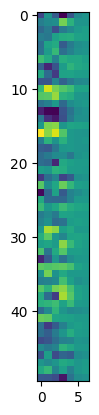

In [41]:
import matplotlib.pyplot as plt
plt.imshow(out[0,0:50,0,:,5])

In [ ]:
### Define model and `optimizer`
op_states = optimizer.init(model_params)

### calculate `grads`
updates, op_states = optimizer.update(grads, op_states, model_params)
new_model_states = optax.apply_updates(model_states, updates)

In [ ]:
random_key = jax.random.PRNGKey(0)
random_key, subkey = jax.random.split(random_key)

# This subkey is "consumed" by `get_model`
model, model_params = get_model(subkey)
# Cast to training dtype
model_params = jax.tree_map(lambda x : x.astype(input_dtype), model_params)

scheduler = optax.constant_schedule(args['lr'])
optimizer = optax.chain(
  optax.clip(1.0),
  optax.adamw(learning_rate=scheduler, weight_decay=1e-4))

# Don't throw the whole model_params in there!! else we'll be optimizing running statistics
op_params = optimizer.init(model_params['params'])
train_state = {'model': model_params, 'op': op_params}
# Broadcast the train state across cores (analagously done for data via "shard")
# Consider: override the name to save memory
pl_train_state = flax.jax_utils.replicate(train_state)

In [ ]:
#from pipeline_utils_jax import accuracy_fn
from jax.scipy.special import logsumexp

metric_fn = optax.l2_loss


criterion = optax.l2_loss

def training_step(apply_fn, update_fn, train_state, batch, subkey):
    def calculate_loss(model_params, apply_fn, batch):
        # Here the model *is* mutable!! set mutable='batch_stats' to enable dropout behavior
        # The mutable state is {'batch_stats': ...} (this bug took me two hours)
        logits, mutable_states = apply_fn(model_params, batch['image'], \
                                    mutable='batch_stats', rngs={'dropout': subkey})
        model_params['batch_stats'] = mutable_states['batch_stats']
        loss = criterion(logits, batch['label'])
        # Sync batch_stats and loss across devices
        model_params['batch_stats'] = jax.tree_map(functools.partial(lax.pmean, axis_name='devices'), \
                                                         model_params['batch_stats'])
        loss = lax.pmean(criterion(logits, batch['label']), 'devices')
        return loss, (logits, model_params)
    
    grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
    (loss, (logits, train_state['model'])), grads = grad_fn(train_state['model'], apply_fn, batch)
    # Only take the gradients for parameters, and sync across devices
    grads = lax.pmean(grads['params'], 'devices')
    
    updates, train_state['op'] = update_fn(grads, train_state['op'], train_state['model']['params'])
    train_state['model']['params'] = optax.apply_updates(train_state['model']['params'], updates)
    
    metric_value = lax.pmean(metric_fn(logits, batch['label']), 'devices')
    return {'train_state': train_state, 'loss': loss, 'metric':metric_value}

def val_step(apply_fn, model_params, batch):
    # Do not enable batch statistic update (mutable=False) ^or^ stochastic behavior
    # We do not need a rng on this forward pass because Dropout is not stochastic anymore
    logits = apply_fn(model_params, batch['image'], mutable=False)
    loss = lax.pmean(criterion(logits, batch['label']), 'devices')
    # Calculate metric
    metric_value = lax.pmean(metric_fn(logits, batch['label']), 'devices')
    return {'loss': loss, 'metric':metric_value}

train_step_parallel = jax.pmap(functools.partial(training_step, apply_fn=model.apply, update_fn=optimizer.update),\
         axis_name='devices')
val_step_parallel = jax.pmap(functools.partial(val_step, apply_fn=model.apply),\
         axis_name='devices')

In [ ]:
def save_checkpoint(log_path, logs, verbose=True):
    with open(log_path, "wb") as outfile:
        outfile.write(msgpack_serialize(to_state_dict(logs)))
    if verbose:
        print("Checkpoint written to:", log_path)
        
def load_checkpoint(log_path, init_log, verbose=True):
    # Read msgpack file
    with open(log_path, "rb") as data_file:
        byte_data = data_file.read()
    if verbose:
        print('Checkpoint retrieved from:', log_path)
    return from_bytes(init_log, byte_data)

In [ ]:
logs = {
    'train_loss': [], 'train_metric': [], 'val_loss': [], 'val_metric': [], 
    'train_state': None, 'args': args}

for epoch in range(args['epochs']):
    ### Training ###
    trainloader = load_dataset(train_filenames, labeled=True, augment=True,\
                    ordered=False, shuffle_buffer_size=4*args['batch_size'], drop_remainder=True)
    # This "total" is specific to batch size!
    counter = tqdm(trainloader, total=199, leave=False)
    pl_train_state['model'] = unfreeze(pl_train_state['model'])
    train_loss, train_metric, train_counter = 0, 0, 0
    for batch in counter:
        random_key, subkey = jax.random.split(random_key)
        out = train_step_parallel(train_state=pl_train_state, batch=batch, subkey=shard_prng_key(subkey))
        pl_train_state = out['train_state']
        loss_value, metric_value = out['loss'][0].item(), out['metric'][0].item()
        
        counter.set_postfix({'loss':loss_value, 'metric':metric_value})
        train_loss += loss_value
        train_metric += metric_value
        train_counter += 1
        if args['sanity_check']:
            break
    pl_train_state['model'] = freeze(pl_train_state['model'])
    train_loss, train_metric = train_loss / train_counter, train_metric / train_counter
    
    
    ### Validation ###
    valloader = load_dataset(val_filenames, labeled=True, augment=False,\
                    ordered=False, shuffle_buffer_size=4*args['batch_size'], drop_remainder=True)
    
    val_steps, val_loss, val_metric = 0, 0, 0
    counter = tqdm(valloader, total=58, leave=False)
    for batch in counter:
        out = val_step_parallel(model_params=pl_train_state['model'], batch=batch)
        loss_value, metric_value = out['loss'][0].item(), out['metric'][0].item()
        val_loss, val_metric, val_steps = val_loss + loss_value, val_metric + metric_value,\
                                        val_steps + 1
        counter.set_postfix({'val_loss':loss_value, 'val_metric':metric_value})
        if args['sanity_check']:
            break
    val_metric, val_loss = val_metric / val_steps, val_loss / val_steps
    
    # Logging
    logs['train_loss'].append(train_loss)
    logs['train_metric'].append(train_metric)
    logs['val_loss'].append(val_loss)
    logs['val_metric'].append(val_metric)
    
    # Checkpointing
    if (val_metric == max(logs['val_metric'])) or (val_loss == min(logs['val_loss'])):
        print(f'Epoch {epoch}, loss:{train_loss:.4f} acc:{train_metric:.4f} val_loss:{val_loss:.4f} val_metric:{val_metric:.4f}')
        out_path = os.path.join(args['saving_dir'], 'checkpoint.msgpack')
        logs['train_state'] = jax.tree_map(lambda x : x.astype(jnp.float16), \
                    flax.jax_utils.unreplicate(pl_train_state))
        save_checkpoint(out_path, logs, verbose=False)
    # load_checkpoint(out_path, logs)

In [ ]:
import numpy as np
import os
import jax.numpy as jnp
from jax import random

class VelDatasetJAX:
    def __init__(self, x_fname, target_fname):
        self.x_fname = x_fname
        self.target_fname = target_fname

    def __len__(self):
        return len(self.x_fname)

    def __getitem__(self, idx):
        file1 = self.x_fname[idx]
        file2 = self.target_fname[idx]
        # Assuming the data is stored in a format that can be directly loaded into a NumPy array
        # Adjust the loading mechanism if your data is stored differently
        low_scale = torch.load(file1)[..., 0]  # Replace with the correct function to load your data
        high_scale = torch.load(file2)[..., 0]  # Replace with the correct function to load your data
        return np.array(low_scale), np.array(high_scale)

def custom_augment(rng, input_array, label_array):
    # Random flip over the middle of the 2nd to last dimension
    if random.uniform(rng) < 0.5:
        input_array = np.flip(input_array, axis=-2)
        label_array = np.flip(label_array, axis=-2)

    # Random flip over the last dimension
    if random.uniform(rng) < 0.5:
        input_array = np.flip(input_array, axis=-1)
        label_array = np.flip(label_array, axis=-1)

    return input_array, label_array

In [ ]:
def batch_generator(dataset, batch_size, shuffle=True, rng_key=random.PRNGKey(0)):
    indices = np.arange(len(dataset))
    if shuffle:
        rng_key, sub_key = random.split(rng_key)
        indices = random.permutation(sub_key, indices)

    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        batch = [dataset[i] for i in batch_indices]

        x_batch, y_batch = zip(*batch)
        x_batch = np.stack(x_batch)
        y_batch = np.stack(y_batch)

        # Apply augmentations
        for i in range(len(x_batch)):
            rng_key, sub_key = random.split(rng_key)
            x_batch[i], y_batch[i] = custom_augment(sub_key, x_batch[i], y_batch[i])

        yield np.array(x_batch), np.array(y_batch)

In [ ]:
import optax
#import jit
# Define your initial learning rate
initial_learning_rate = 0.001
import numpy as np
import pandas as pd
import os
from jax import grad, jit
import h5py
#import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

base_dir = '/kaggle/input/pflotran-data/'
f_dir = os.listdir(base_dir)
h5_files = []
h5_files_train = []
h5_files_train_1x = []
# Iterate over all files in the directory
for filename in f_dir:
    if (filename.endswith(".pt")) & ((("2x" in filename))):
        h5_files_train.append(base_dir+filename)
    if (filename.endswith(".pt")) & ((("1x" in filename))):
        h5_files_train_1x.append(base_dir+filename)
#     if (filename.endswith(".h5")) & (("8x" in filename)):
#         if (("10_5" not in filename) & ("20_20" not in filename)):
#             h5_files_train.append(base_dir+filename)
    if (filename.endswith(".pt")) & ((("10x" in filename))):
#         if (("10_5" in filename) | ("20_20" in filename)):
        h5_files.append(base_dir+filename)
# Run the processing in parallel
h5_files = np.array(h5_files)
h5_files_train = np.array(h5_files_train)
arr = h5_files
contains_hanford = np.array(['hanford' in item for item in arr])

# Alphabetical sorting key
alphabetical_order = np.argsort(arr)

# Prioritize "hanford" and then sort alphabetically within each group
sorted_indices = np.lexsort((alphabetical_order, ~contains_hanford))

# Use sorted indices to reorder the array
sorted_arr = arr[sorted_indices]
sorted_arr

sorted_arr2 = h5_files_train[sorted_indices]
xtest = sorted_arr2[0:33:5]
xtrain = sorted_arr2[34::5]#np.concatenate([sorted_arr2[33:50:3], sorted_arr2[50:]])


ytest = sorted_arr[0:33:5]
ytrain = sorted_arr[34::5]#np.concatenate([sorted_arr[33:50:3], sorted_arr[50:]])
print(ytrain)

#h5_files = h5_files[0:6]
#h5_files_train = h5_files_train[0:6]
from torch.utils.data import Dataset

h5_files = np.sort(h5_files)
h5_files_train=np.sort(h5_files_train)
h5_files_train_1x=np.sort(h5_files_train_1x)

num_time_steps = 80
num_features = 6  # As obs

# Define your decay rate and steps
decay_rate = 0.99
decay_steps = 100
dataset = VelDatasetJAX(xtrain, xtrain)
# Create an exponentially decaying learning rate schedule
# lr_schedule = optax.exponential_decay(init_value=initial_learning_rate,
#                                       transition_steps=decay_steps,
#                                       decay_rate=decay_rate)

# # Combine the learning rate schedule with your optimizer
# optimizer = optax.chain(
#     optax.scale_by_adam(),  # Or any other optimizer
#     optax.scale_by_schedule(lr_schedule)
# )
# def model_fn(params, x):
#     # Dummy model function
#     return x @ params

# def loss_fn(params, x, y):
#     # Example loss function
#     preds = model_fn(params, x)
#     return jnp.mean((preds - y) ** 2)


# # Initialize your model parameters and optimizer state
# params = jax.random.normal(jax.random.PRNGKey(0), (14,114,100,400))  # Example model parameters initialization
# opt_state = optimizer.init(params)

# # Update function with learning rate schedule
# @jax.jit
# def update(params, opt_state, x, y, step):
#     grads = grad(loss_fn)(params, x, y)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     new_params = optax.apply_updates(params, updates)
#     return new_params, opt_state

# # Training loop with LR scheduler
# epochs = 10
# batch_size = 32
# steps_per_epoch = len(dataset) // batch_size
# total_steps = epochs * steps_per_epoch

# for epoch in range(epochs):
#     rng_key = jax.random.PRNGKey(epoch)  # New RNG key for each epoch
#     step = 0
#     for x_batch, y_batch in batch_generator(dataset, batch_size, rng_key=rng_key):
#         params, opt_state = update(params, opt_state, x_batch, y_batch, step)
#         step += 1
#     print(f"Epoch {epoch+1} completed.")

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from jax import random

# Assuming `xtrain` and `ytrain` are pre-processed datasets compatible with JAX
# Assuming custom_augment function is adjusted for JAX, using jax.numpy operations

class UpsampleSmall(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.repeat(40, axis=3)  # Assuming the equivalent operation is performed for JAX arrays
        x = nn.Dense(features=8000)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(features=4000)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(features=2000)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(features=2000)(x)
        return x

def mse_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

#@jax.jit
def update(params, opt_state, x, y):
    grads = grad(mse_loss)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# Initialize parameters
rng = random.PRNGKey(0)
init_rng, dropout_rng = random.split(rng)
init_shape = jnp.ones((2, 114, 100,400), jnp.float32)  # Example input shape
params = UpsampleSmall().init(init_rng, init_shape)['params']

# Initialize optimizer
optimizer = optax.adam(learning_rate=0.0001)
opt_state = optimizer.init(params)
batch_size=2
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Example: Update parameters using a single batch (x_batch, y_batch)
    # In practice, iterate over your dataset here
    rng_key = jax.random.PRNGKey(epoch)
    for x_batch, y_batch in batch_generator(dataset, batch_size, rng_key=rng_key):
        updates, opt_state = update(optimizer, params, x_batch, y_batch)
        params = optax.apply_updates(params, updates)
    

In [ ]:
jax.clear_caches()

In [ ]:
loaded_npz1['high_losing_27_8_10xscale/data.pkl']

## New Jax Section

In [1]:
import os
import warnings
import tensorflow as tf
import jax
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Seems like the new one will break jax
#!pip install --upgrade jax jaxlib==0.4.3 git+https://github.com/deepmind/optax.git flax optax -q
    
if 'TPU_NAME' in os.environ and 'KAGGLE_DATA_PROXY_TOKEN' in os.environ:
    use_tpu = True
    
    import requests 
    from jax.config import config
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    # Enforce bfloat16 multiplication
    config.update('jax_default_matmul_precision', 'bfloat16')
    print('Registered (Kaggle) TPU:', config.FLAGS.jax_backend_target)
else:
    use_tpu = False

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [4]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [400, 4000, 2000]
step_size = 0.001
num_epochs = 80
batch_size = 16
n_targets = 16
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [5]:
(params[0][1].shape)

(4000,)

In [6]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
    # Assuming image has shape [batch, ..., features]
    activations = image
    for w, b in params[:-1]:
        # Reshape activations to [-1, features] to treat all leading dims as batch dims
        original_shape = activations.shape[:-1]  # Save original shape without the last dim
        features = activations.shape[-1]
        activations_reshaped = activations.reshape(-1, features)
        
        # Perform operations on the reshaped activations
        outputs = jnp.dot(activations_reshaped, w.T) + b  # Note: Adjusted for correct matrix multiplication
        activations = relu(outputs)
        
        # Reshape back to original batch dims with new features
        activations = activations.reshape(*original_shape, -1)

    # Handle the final layer
    final_w, final_b = params[-1]
    activations_reshaped = activations.reshape(-1, activations.shape[-1])
    logits = jnp.dot(activations_reshaped, final_w.T) + final_b
    logits = jnp.reshape(logits, (114, 100, 2000))
    # No need to reshape logits back, unless you have a specific reason to maintain the original batch shape

    return logits #- logsumexp(logits, axis=-1, keepdims=True)

In [7]:
# random_flattened_image = random.normal(random.PRNGKey(1), (114,100,400,))
# preds = predict(params, random_flattened_image)
# print(preds.shape)

In [8]:
# # Doesn't work with a batch
# random_flattened_images = random.normal(random.PRNGKey(1), (10,114,100,400,))
# try:
#   preds = predict(params, random_flattened_images)
# except TypeError:
#   print('Invalid shapes!')

In [9]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
#batched_preds = batched_predict(params, random_flattened_images)
#print(batched_preds.shape)

In [10]:
from jax import value_and_grad
import optax

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return jnp.mean(optax.l2_loss( preds, targets))

def update(params, opt_state, x, y):
    # Compute the loss and gradients
    loss_value, grads = value_and_grad(loss)(params, x, y)
    
    # Apply the optimizer to update the gradients and the optimizer state
    updates, new_opt_state = optimizer.update(grads, opt_state)
    
    # Apply updates to the parameters
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_value

In [16]:
x.shape

(16, 114, 100, 400)

In [19]:
import numpy as np
import os
import jax.numpy as jnp
from jax import random
import torch 
import torch.nn.functional as F

class VelDatasetJAX:
    def __init__(self, x_fname, target_fname):
        self.x_fname = x_fname
        self.target_fname = target_fname

    def __len__(self):
        return len(self.x_fname)

    def __getitem__(self, idx):
        file1 = self.x_fname[idx]
        file2 = self.target_fname[idx]
        # Assuming the data is stored in a format that can be directly loaded into a NumPy array
        # Adjust the loading mechanism if your data is stored differently
        low_scale = torch.load(file1)[20:52,:,100:100+224,:] 
        low_scale = low_scale.permute(3,0,1,2)
        # Replace with the correct function to load your data
        high_scale = torch.load(file2)[20:52,:,500:int(500+224*5),0]  # Replace with the correct function to load your data
        low_scale = F.interpolate(low_scale,  # Add batch dimension
                                      size=(224,224),  # target size
                                      mode='bicubic',  # or 'nearest', 'bicubic'
                                      align_corners=False)
        
        #low_scale = low_scale.permute(1,2,3,0)
        low_scale = low_scale.repeat(3, 1, 1, 1)#.permute(3,0,1,2)
        

        print (low_scale.shape)
        return low_scale, high_scale

# def custom_augment(rng, input_array, label_array):
#     # Random flip over the middle of the 2nd to last dimension
#     if random.uniform(rng) < 0.5:
#         input_array = np.flip(input_array, axis=-2)
#         label_array = np.flip(label_array, axis=-2)

#     # Random flip over the last dimension
#     if random.uniform(rng) < 0.5:
#         input_array = np.flip(input_array, axis=-1)
#         label_array = np.flip(label_array, axis=-1)

   # return input_array, label_array

In [20]:
base_dir = '/kaggle/input/pflotran-data/'
f_dir = os.listdir(base_dir)
h5_files = []
h5_files_train = []
h5_files_train_1x = []
# Iterate over all files in the directory
for filename in f_dir:
    if (filename.endswith(".pt")) & ((("2x" in filename))):
        h5_files_train.append(base_dir+filename)
    if (filename.endswith(".pt")) & ((("1x" in filename))):
        h5_files_train_1x.append(base_dir+filename)
#     if (filename.endswith(".h5")) & (("8x" in filename)):
#         if (("10_5" not in filename) & ("20_20" not in filename)):
#             h5_files_train.append(base_dir+filename)
    if (filename.endswith(".pt")) & ((("10x" in filename))):
#         if (("10_5" in filename) | ("20_20" in filename)):
        h5_files.append(base_dir+filename)
# Run the processing in parallel
h5_files = np.array(h5_files)
h5_files_train = np.array(h5_files_train)
arr = h5_files
contains_hanford = np.array(['hanford' in item for item in arr])

# Alphabetical sorting key
alphabetical_order = np.argsort(arr)

# Prioritize "hanford" and then sort alphabetically within each group
sorted_indices = np.lexsort((alphabetical_order, ~contains_hanford))

# Use sorted indices to reorder the array
sorted_arr = arr[sorted_indices]
sorted_arr

sorted_arr2 = h5_files_train[sorted_indices]
xtest = sorted_arr2[0:33]
xtrain = sorted_arr2[34:]#np.concatenate([sorted_arr2[33:50:3], sorted_arr2[50:]])


ytest = sorted_arr[0:33]
ytrain = sorted_arr[34:]#np.concatenate([sorted_arr[33:50:3], sorted_arr[50:]])
print(ytrain)

['/kaggle/input/pflotran-data/high_losing_27_8_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_14_10_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_right_38_16_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_34_15_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_47_9_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_22_21_10xscale.pt'
 '/kaggle/input/pflotran-data/gaining_51_10_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_right_41_17_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_37_9_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_right_46_10_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_37_9_10xscale.pt'
 '/kaggle/input/pflotran-data/gaining_34_6_10xscale.pt'
 '/kaggle/input/pflotran-data/high_gaining_right_49_24_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_14_10_10xscale.pt'
 '/kaggle/input/pflotran-data/gaining_49_10_10xscale.pt'
 '/kaggle/input/pflotran-data/high_losing_35_23_10xscale.pt'
 '/kaggle/i

In [21]:
import numpy as np
from jax.tree_util import tree_map
from torch.utils import data
from torchvision.datasets import MNIST
import tensorflow as tf

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=True,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [22]:
#mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
pflotran_dataset = VelDatasetJAX(xtrain, ytrain)
batch_size=8
training_generator = NumpyLoader(pflotran_dataset, batch_size=batch_size, num_workers=0, drop_last=True)

In [24]:
x,y=next(iter(training_generator))
x = tf.cast(x, tf.float32)
x.dtype

torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])
torch.Size([3, 32, 224, 224])


tf.float32

In [16]:
# # Get the full train dataset (for checking accuracy while training)
# train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
# train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# # Get full test dataset
# mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
# test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
# test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

In [1]:
import time
import optax 

optimizer = optax.adam(learning_rate=.0004)
opt_state = optimizer.init(params)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in training_generator:
    #y = one_hot(y, n_targets)
    params, opt_state, loss_val =  update(params, opt_state, x, y)
    epoch_time = time.time() - start_time
    #preds = batched_predict(params, x)
    #MSE = jnp.mean(optax.l2_loss( preds, y))
    #train_acc = accuracy(params, train_images, train_labels)
    #test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set loss {}".format(loss_val))
    #print("Test set accuracy {}".format(test_acc))

NameError: name 'params' is not defined

In [ ]:
preds = batched_predict(params, x)
preds.shape

In [12]:
import matplotlib.pyplot as plt
#plt.imshow(preds[2,110,:,:])

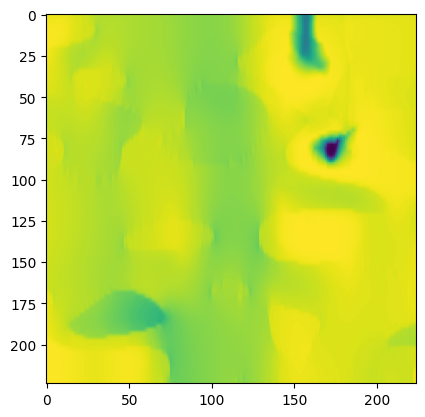

In [62]:
plt.imshow(x[0,110,:,:])